In [1]:
using Pkg;
Pkg.activate(".")
using Plots, CSV, DataFrames, Polynomials, LinearAlgebra

  Activating project at `~/Documents/Spring2024/NumericalAnalysis/NA-FinalProject/src`


### Procedure
1. Parse data

The spline algorithms only work if the x-values of the data are in ascending order. This also means that if, in the same data recording, I walk forward, and then backwards, the algorithm won't work. To account for this we will sort the data

In [31]:
# This will create a dataframe from our file
filename = "../data/03-26-Stadium/Location.csv"
data = CSV.File(open(filename)) |> DataFrame

# using the longitude as our x-values and the altitude as our y-values
# dataframes makes it easy to get these values by using the dot syntax

#USE LATITUDE FOR X-VALUES IN OUR TESTING (THIS DATA IS TAKEN GOING E-W, not N-S)
x = data.longitude;
y = data.altitude;

#sort the x values to account for any wobble in the data
x_sorted = sort(x, rev=true);


2. Sample some points from the sorted data

In [51]:
"""
     get_spaced_points(x_sorted, y, n=10)

Takens in sorted x and y values, returns 'n' number of equally spaced out
points from the data. If inputted x-values are in increasing order, set rev=false
"""
function get_spaced_points(x_sorted, y, n=10; rev=true)
     len = length(x_sorted)
     indices = round.(Int, LinRange(1, len, n))
    
     if rev
          xs = reverse(x_sorted[indices])
          ys = reverse(y[indices])
     else
          xs = x_sorted[indices]
          ys = y_sorted[indices]
     end

     return xs, ys
 end

get_spaced_points

In [53]:
xs, ys = get_spaced_points(x_sorted, y);

3. Setup cubic interpolation method

This is taken directly from the textbook, it appears to be working currently. He uses a different naming convention. To convert
His '$t$' == my '$xs$'  ,   His '$y$' == my '$ys$'

This takens in a sample and returns a function that fits these samples. To plot, we feed into the returned function our data points

In [55]:
"""
    spinterp(t,y)

Construct a cubic not-a-knot spline interpolating function for data
values in `y` given at nodes in `t`.
"""
function spinterp(t,y)
    n = length(t)-1
    h = [ t[k+1]-t[k] for k in 1:n ]

    # Preliminary definitions.
    Z = zeros(n,n);
    In = I(n);  E = In[1:n-1,:];
    J = diagm(0=>ones(n),1=>-ones(n-1))
    H = diagm(0=>h)

    # Left endpoint interpolation:
    AL = [ In Z Z Z ]
    vL = y[1:n]

    # Right endpoint interpolation:
    AR = [ In H H^2 H^3 ];
    vR = y[2:n+1]

    # Continuity of first derivative:
    A1 = E*[ Z J 2*H 3*H^2 ]
    v1 = zeros(n-1)

    # Continuity of second derivative:
    A2 = E*[ Z Z J 3*H ]
    v2 = zeros(n-1)

    # Not-a-knot conditions:
    nakL = [ zeros(1,3*n) [1 -1 zeros(1,n-2)] ]
    nakR = [ zeros(1,3*n) [zeros(1,n-2) 1 -1] ]

    # Assemble and solve the full system.
    A = [ AL; AR; A1; A2; nakL; nakR ]
    v = [ vL; vR; v1; v2; 0; 0 ]
    z = A\v

    # Break the coefficients into separate vectors.
    rows = 1:n
    a = z[rows]
    b = z[n.+rows];  c = z[2*n.+rows];  d = z[3*n.+rows]
    S = [ Polynomial([a[k],b[k],c[k],d[k]]) for k in 1:n ]

    # This function evaluates the spline when called with a value
    # for x.
    return function (x)
        if x < t[1] || x > t[n+1]    # outside the interval
            return NaN
        elseif x==t[1]
            return y[1]
        else
            k = findlast(x .> t)    # last node to the left of x
            return S[k](x-t[k])
        end
    end
end

spinterp

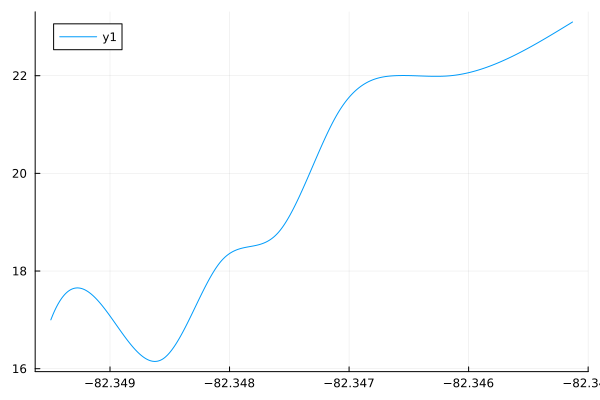

In [58]:
cspline_f = spinterp(xs, ys)
plot(x_sorted, cspline_f.(x_sorted))

Plotting it over top of our original data

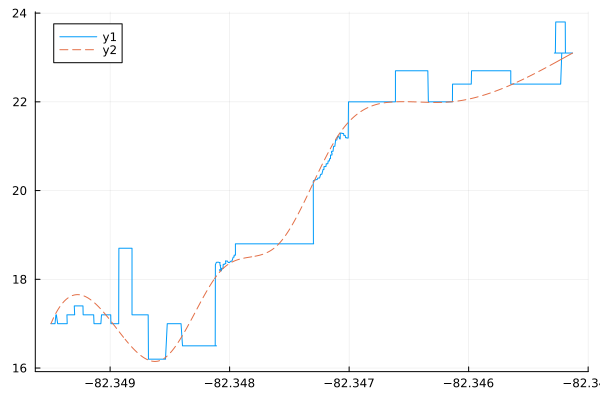

In [62]:
plt = plot(x, y)
plot!(plt, x, cspline_f.(x), ls=:dash)

Since I built the model using the sorted x-values, it's probably more accurate to show it overlaid on that plot instead

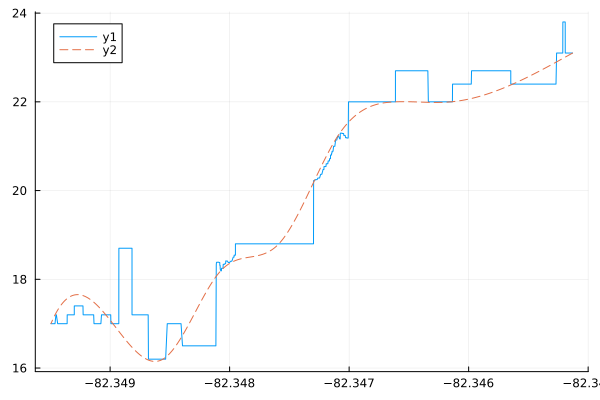

In [63]:
plt = plot(x_sorted, y)
plot!(plt, x_sorted, cspline_f.(x_sorted), ls=:dash)

4. Piece together into an easily usable function
   
I've opted for a function that plots an overlay of the spline onto a preexisting plot. I think this makes it easy to plot a bunch of splines at different values of n

In [65]:
function plot_cubic_spline(plt, x, y, n=10; alpha=0.6)
     x_sorted = sort(x, rev=true);
     xs, ys = get_spaced_points(x_sorted, y);
     cspline_f = spinterp(xs, ys)
     plot!(plt, x_sorted, cspline_f.(x_sorted), label="n=$n",ls=:dash, alpha=alpha)
end

plot_cubic_spline (generic function with 2 methods)

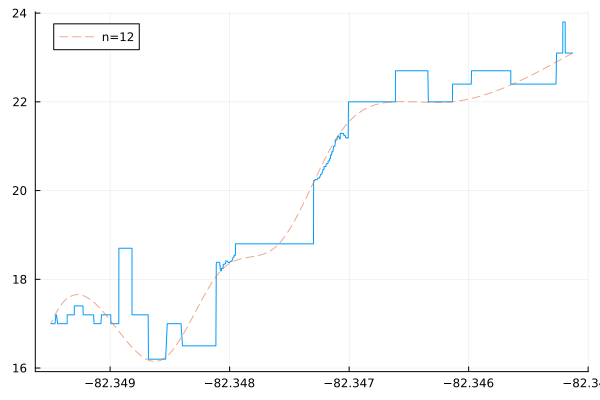

In [67]:
plt = plot(x_sorted, y, label=:none)
plot_cubic_spline(plt, x, y, 12)